In [1]:
# Importing necessary libraries for data cleaning and exploration

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, f1_score

from Utils.preprocessing import *
from Utils.customPipelines import *

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE=632

In [58]:
# We want to difference the data to find the n-day returns
def get_differenced_data(df_temp, p=1):
    df_diff = df_temp[[col for col in df_temp.columns if col != 'Date']].diff(periods=p)
    df_diff["Date"] = df_temp["Date"]
    return df_diff.dropna().reset_index(drop=True)


In [3]:
# Load the dataset
df = pd.read_csv('data\\QF632_Project_1.csv')

# Change date format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# We set our forecast horizon early to compare runs between horizons
h = 1

# 1. Review the quality of the data, 
List any potential errors, and propose corrected values. Please list each quality check errorand correction applied.

- Check row types are consistent (all float64)
- Remove duplicates
- Forward fill NaN values
- Check date format and sequence is correct
- Forward fill negative values in signal & ETF prices

In [4]:
# Examine the structure and summary
print(df.info())
print(df.describe())
print()

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:\n", missing_values)
print()

# Check for duplicates
duplicates = df.duplicated().sum()
print("Number of duplicate rows:", duplicates)
print()

# Ensure dates are in the right format and sequence
date_check = df['Date'].apply(pd.to_datetime, errors='coerce').isnull().sum()
print(f"Invalid dates: {date_check}")

# Check for date sequence issues
date_order_issues = (df['Date'] != df['Date'].sort_values()).any()
if date_order_issues:
    print("Dates are out of order")
else:
    print("Dates are in correct order")
print()

# Ensure prices and signals are non-zero and positive
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
value_check = {col: (df[col] < 0).sum() for col in columns_to_check}

print(f"Negative/zero values: {value_check}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1038 non-null   datetime64[ns]
 1   Signal     1038 non-null   float64       
 2   Open       1038 non-null   float64       
 3   High       1038 non-null   float64       
 4   Low        1038 non-null   float64       
 5   Close      1038 non-null   float64       
 6   Adj Close  1038 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 56.9 KB
None
                                Date       Signal         Open         High  \
count                           1038  1038.000000  1038.000000  1038.000000   
mean   2017-12-11 17:03:48.901734144    16.766190   141.847360   142.691801   
min              2015-11-19 00:00:00     0.000000    94.080002    95.400002   
25%              2016-11-30 06:00:00    14.691150   132.132496   132.912495   
50%        

In [5]:
columns_to_check = ['Signal', 'Open', 'High', 'Low', 'Close', 'Adj Close']
# Correcting negative/zero historical prices and signal values using forward fill
for col in columns_to_check:
    # Replace zero and negative values with NaN
    df[col] = df[col].mask(df[col] <= 0)
    
    # Forward fill NaN values
    df[col].fillna(method='ffill', inplace=True)

In [6]:
df_diff = get_differenced_data(df.copy(), h)

# 2. Run any exploratory data analysis you think is important and highlight any interesting insights you come across

## 2a(i). Visualising the data

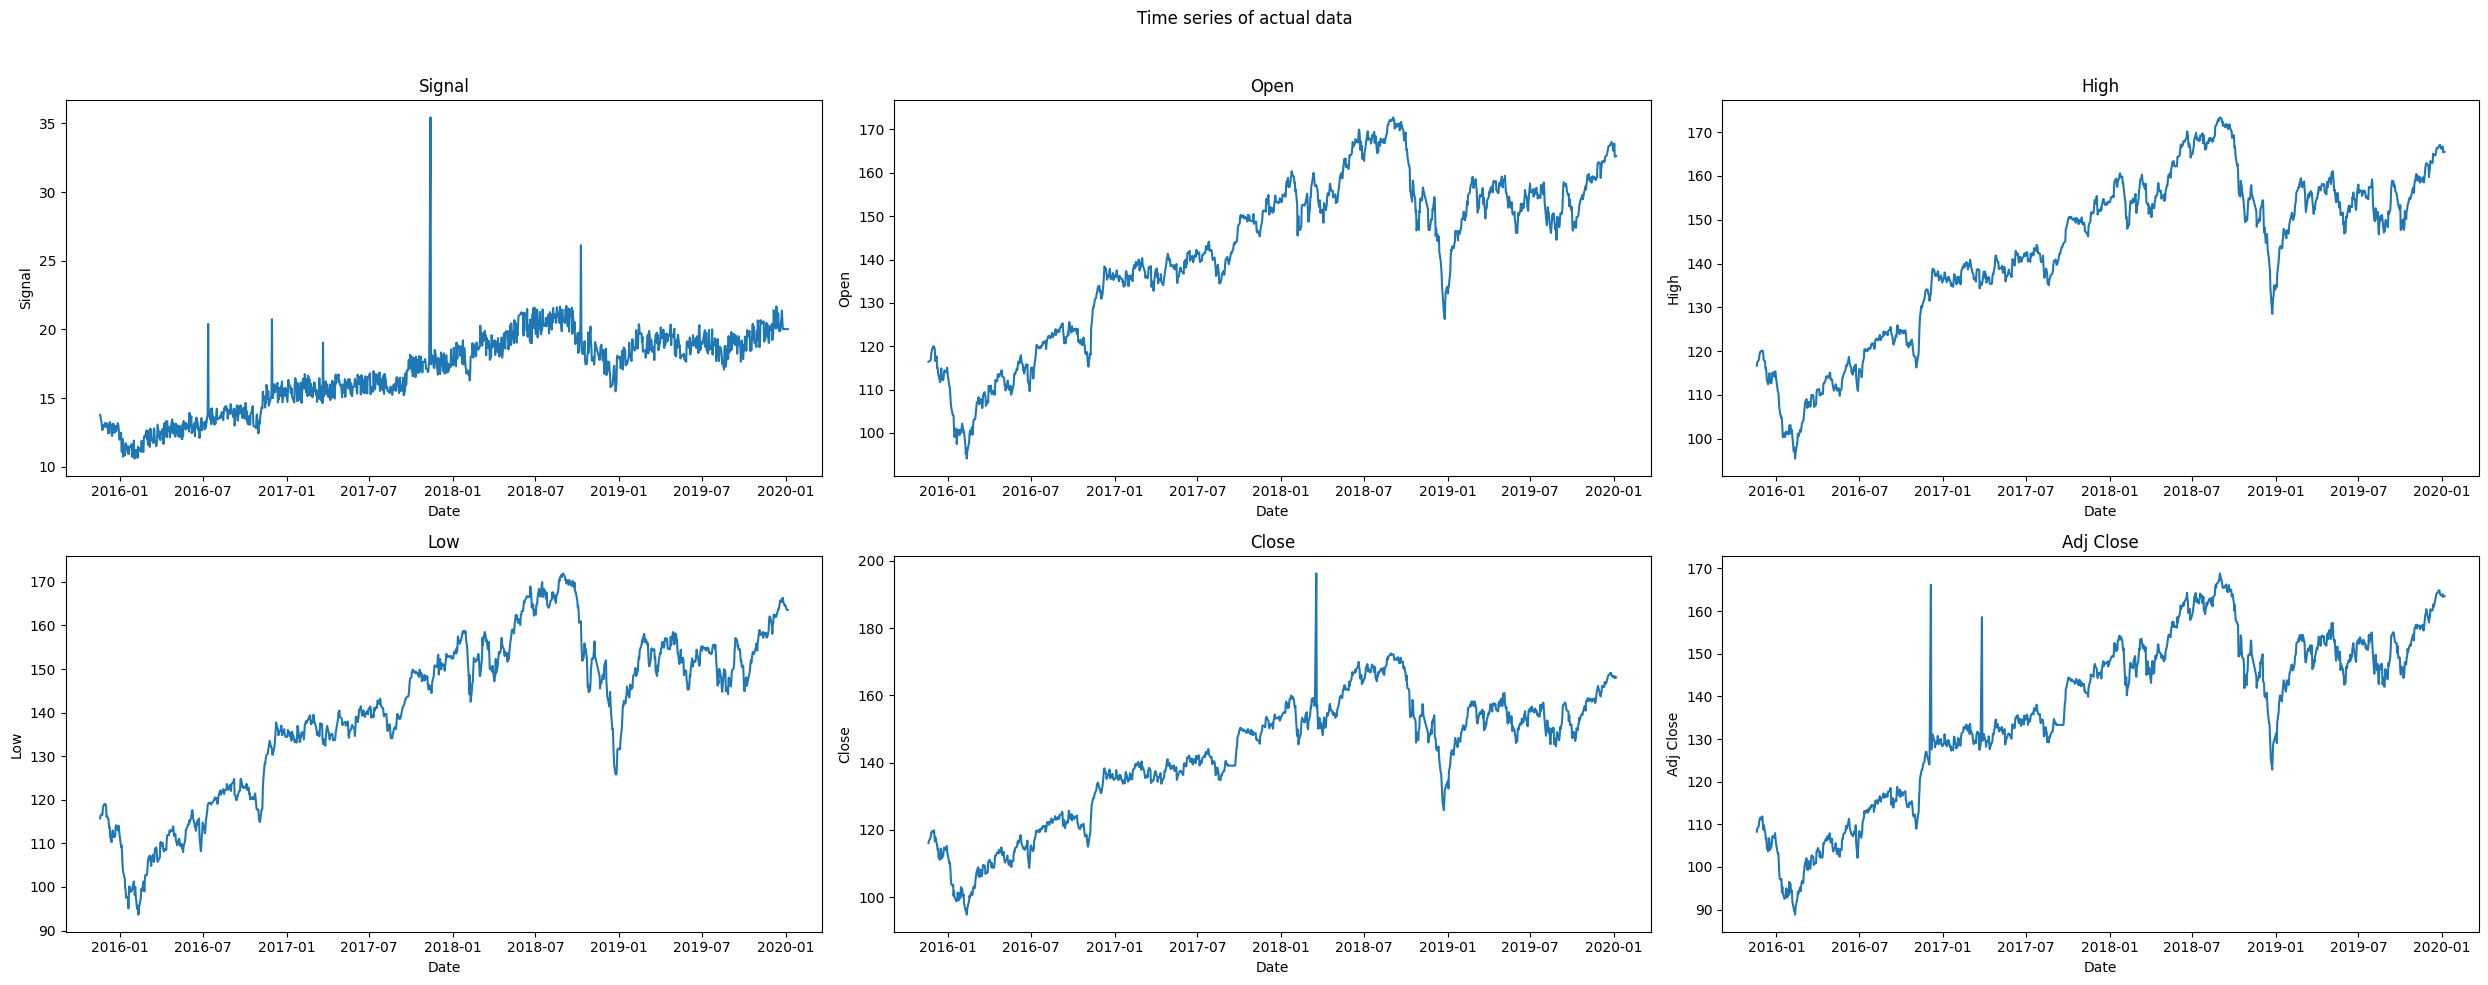

In [51]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Time series of actual data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df.Date, y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

- 2016 - end 2018: There is an upward trend. Prices of ETF seems to be additive as it's variance is rather constant. Some outliers present in the close and Adjusted Close price. 4 points of outliers in signal.
- End 2018 - mid 2019: There is a sharp dip followed by a prompt recovery of similar steepness.
- Mid 2019 - End of data: No trend observed. We can observe something akin to quarterly seasonality. Unclear if the final rise in 2020 is as a result of increasing trend or quarterly seasonality.

## 2a(ii). Visualising differenced data

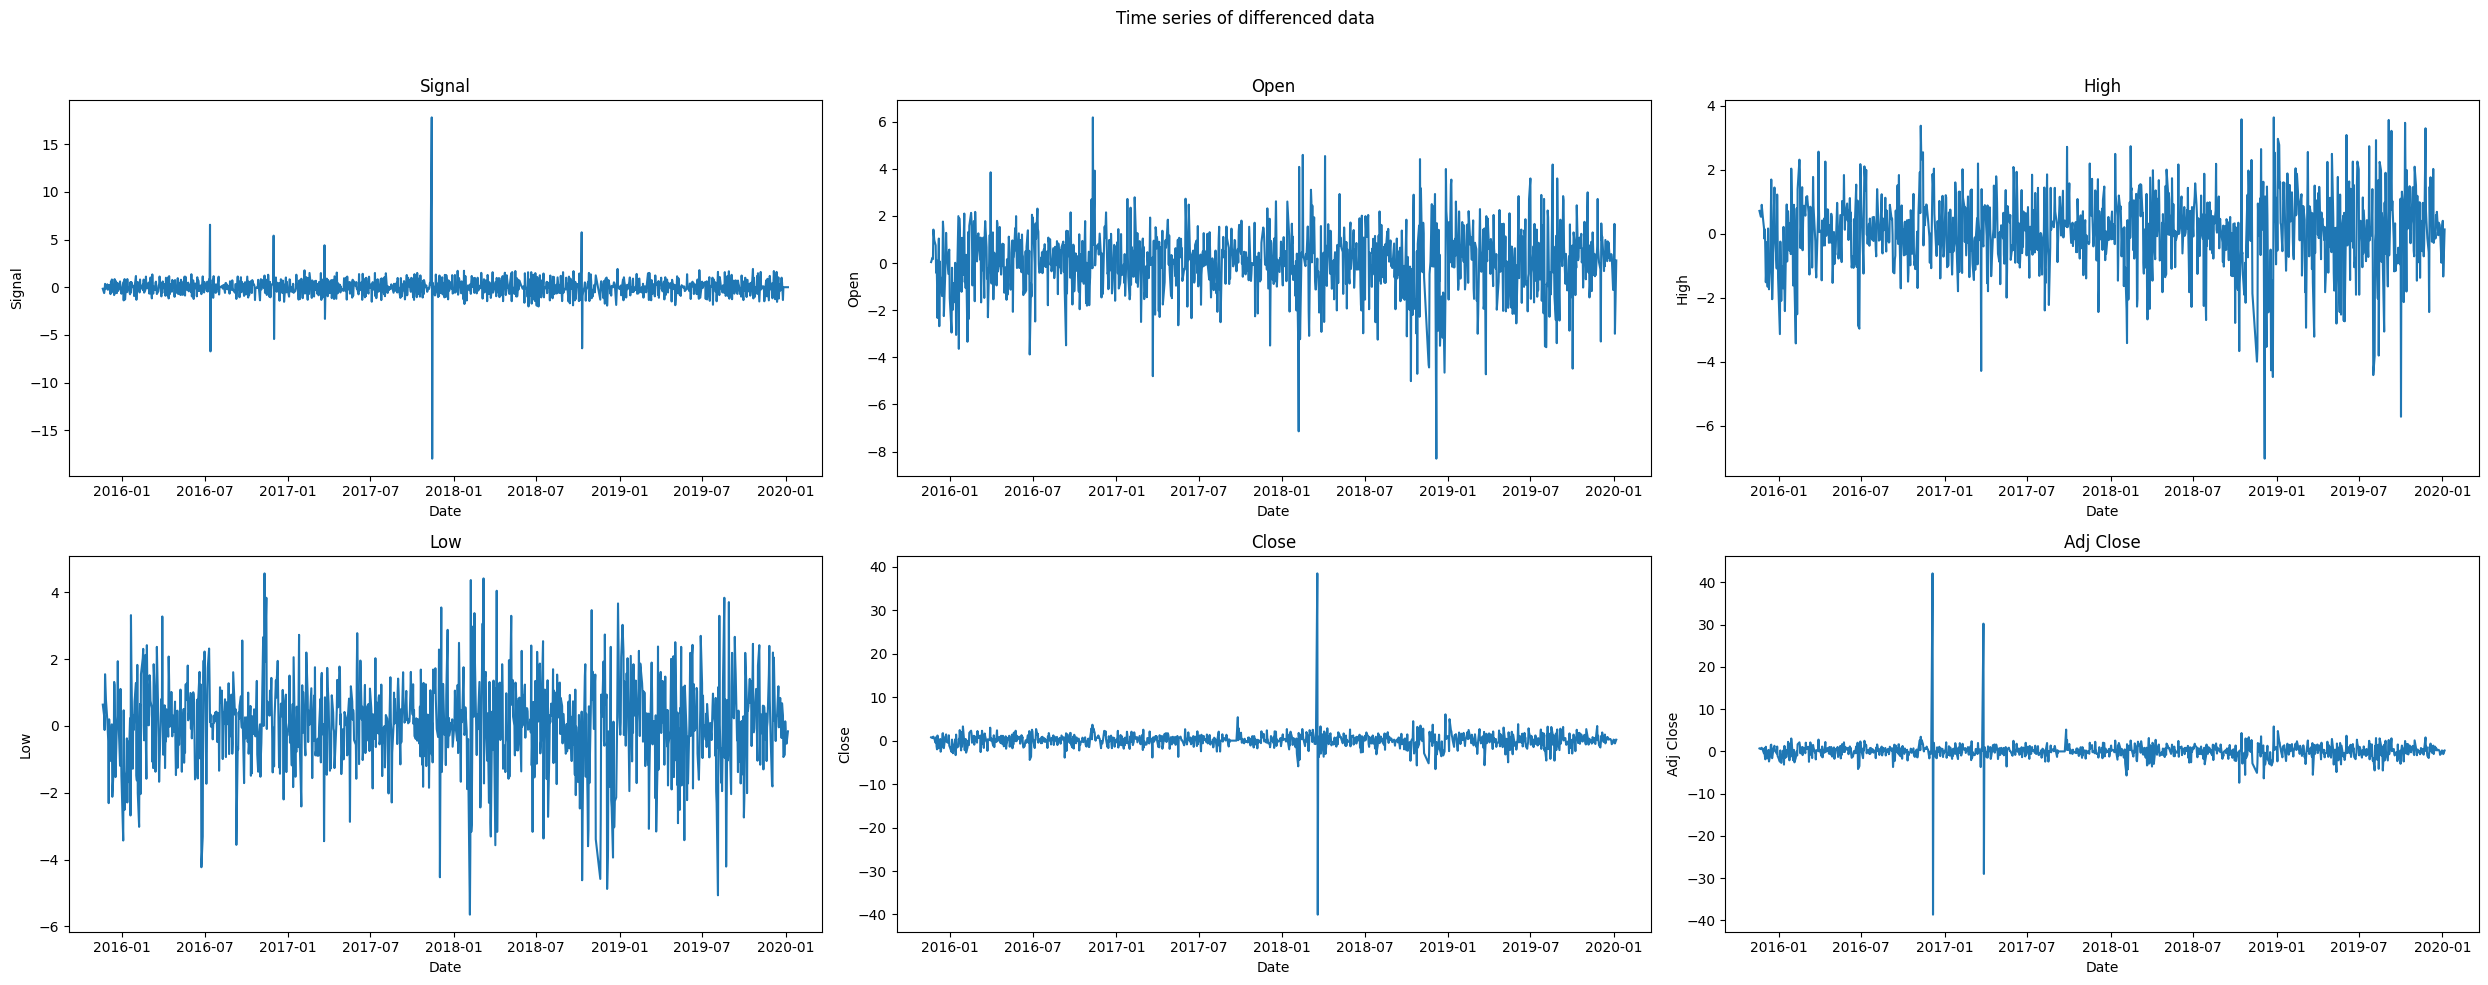

In [52]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Time series of differenced data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_diff.Date, y=df_diff[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 2b. Time Series Decomposition

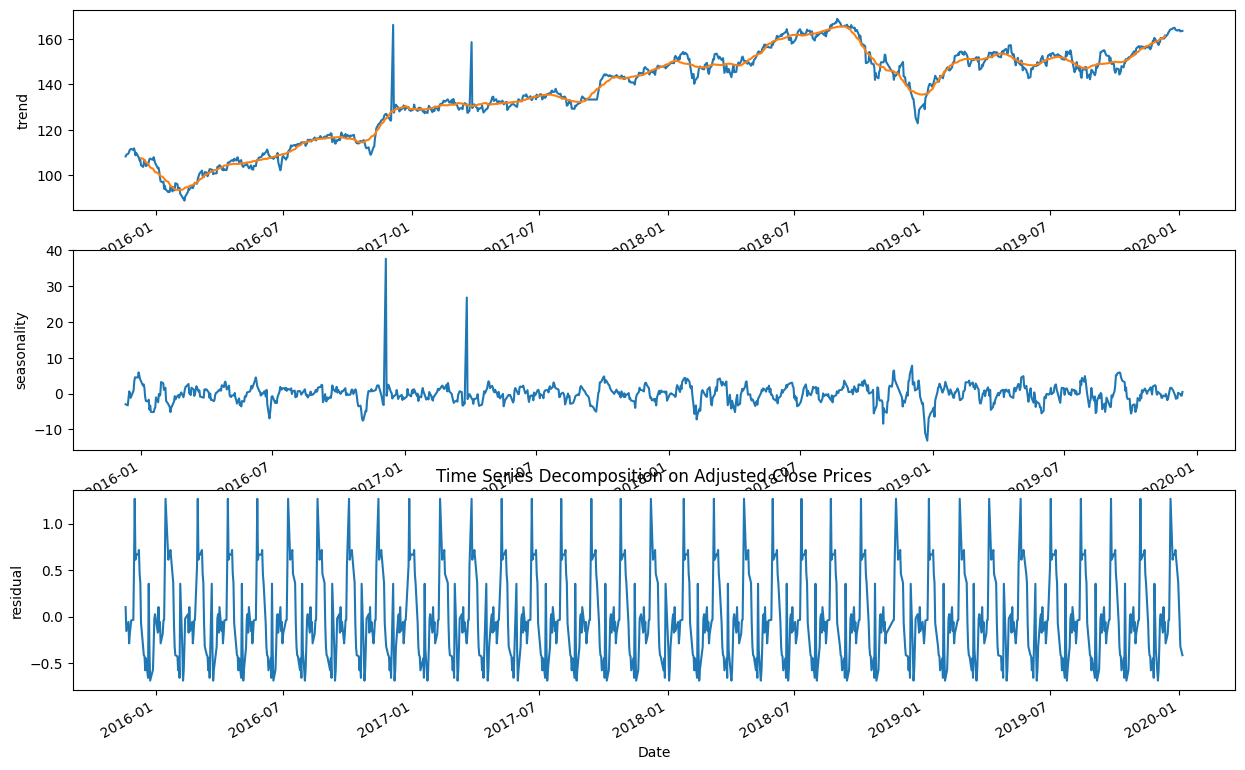

In [54]:
df_decomp = df.copy()
df_decomp.index = df_decomp.Date

res = seasonal_decompose(df_decomp["Adj Close"], model = "additive",period = 30)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,10))
res.observed.plot(ax=ax1,ylabel = "trend")
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasonality")
res.seasonal.plot(ax=ax3,ylabel = "residual")

plt.title("Time Series Decomposition on Adjusted Close Prices")
plt.show()

We decompose the adjusted close data as it is the most representative of ETF prices, using the additive method. From the plots above, we can determine that there is still time-series information left in the residuals after decomposition as we see a clear pattern there. The trend in general goes upwards, and there doesn't seem to be any strong seasonality in this set of data.

## 2c. ACF/PACF

Autocorrelation represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals. In other words, it measures the relationship between a variable’s current value and its past values.

PACF measures the relationship between a variable’s current value and its past values unconditional to the preceeding lags.


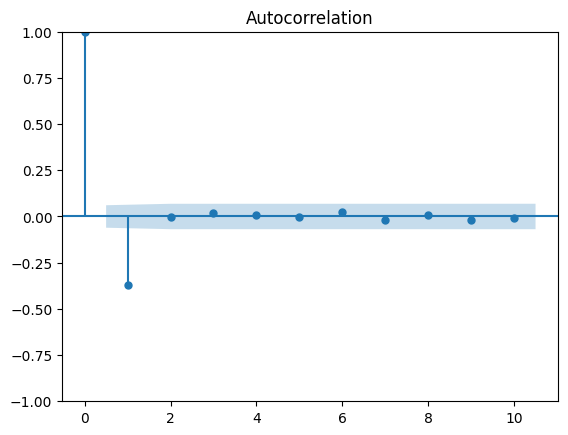

In [55]:
sm.graphics.tsa.plot_acf(df_diff["Adj Close"].dropna(), lags=10)
plt.show()

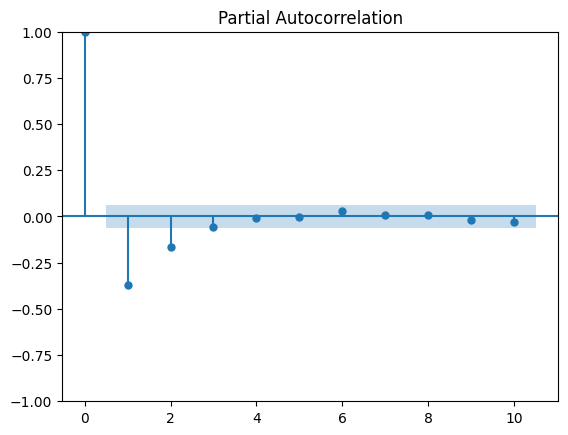

In [56]:
sm.graphics.tsa.plot_pacf(df_diff["Adj Close"].dropna(), lags=10)
plt.show()

ACF is significant at lag 1, whereas PACF is shows a geometric decay at each m lag. This can signify a moving average (MA) component in an ARIMA model if used.  

## 2d(i). Outlier Detection - Boxplots

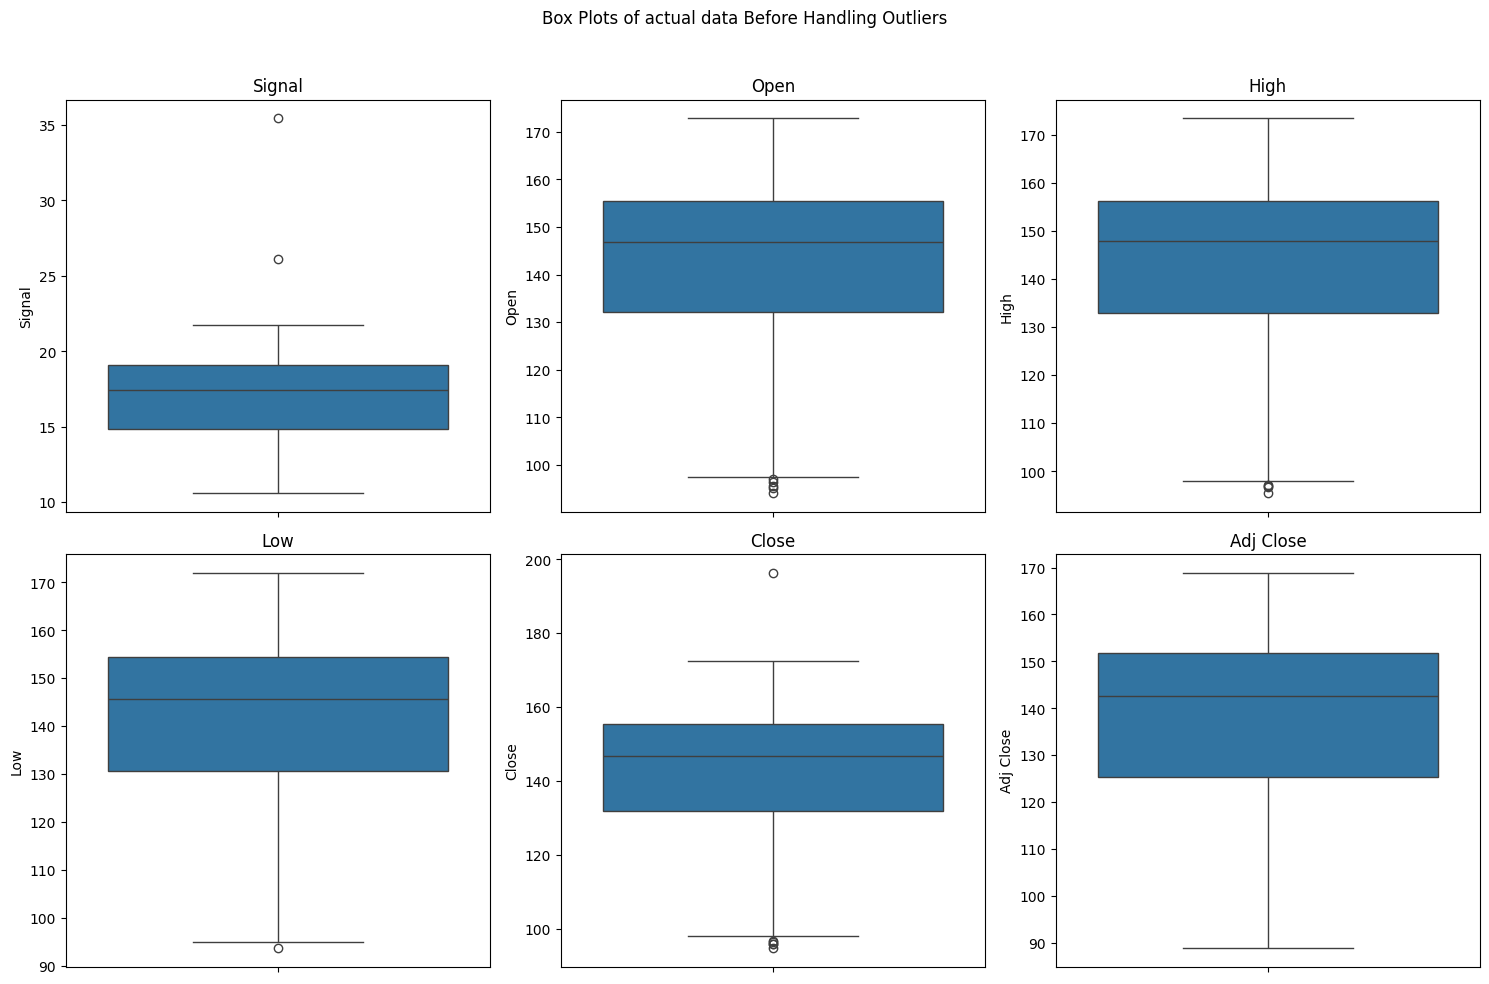

In [7]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots of actual data Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Extreme high outliers:
- Signal has 2 points 
- Close has 1 oint

Extreme low points:
- All columns except Adj Close

This is interesting as this means that after removing all volatility from day to day trades as well as taking into account corporate actions such as stock splits, dividends, and mergers, the actual price of ETF does not seem to have any outliers.

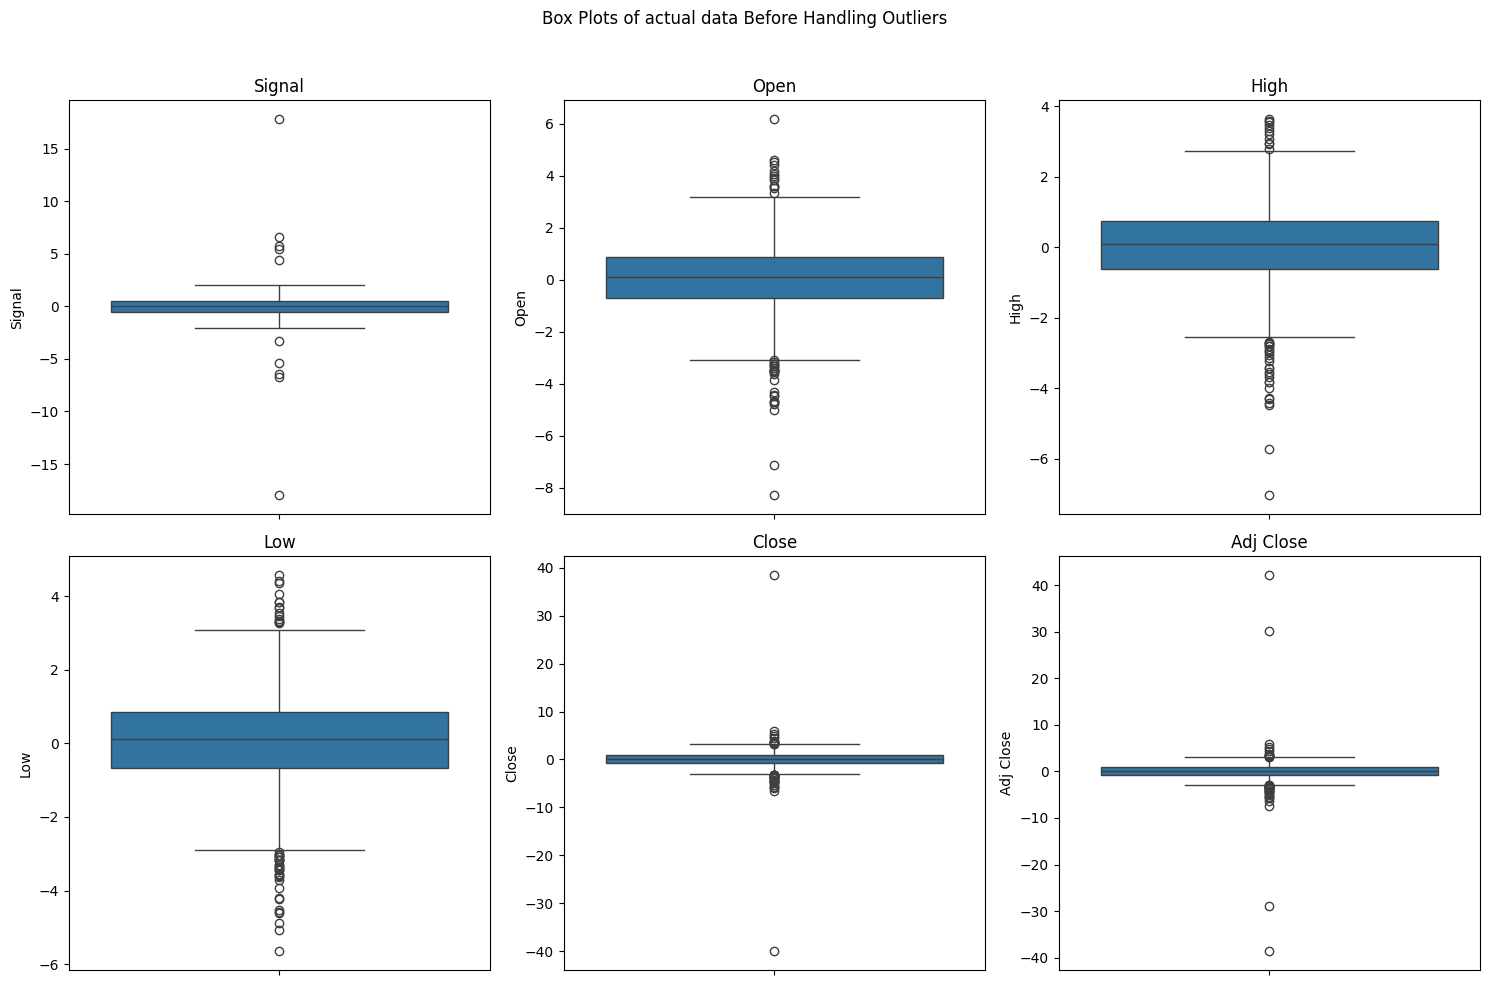

In [8]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots of actual data Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_diff[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

After differencing the data by 1 period, we see that outliers are more apparent in all columns

Rate of change of all prices seem to be normally distributed with a mean of 0. The kurtosis of signal, close and adjusted close returns of ETF are significantly higher than the rest of the columns.

## 2d(ii). Outlier handling

In [11]:
# Function to handle large increases by forward filling
def handle_large_increases_ffill(differences, columns, multiplier):
    # Identify data points with increases more than 10 times the average move
    for col in columns:
        large_increases = []
        col_diff = differences[col]
        for i in range(len(differences)//10, len(differences)):
            avg_movement = col_diff[:i-1].abs().mean()
            std_movement = col_diff[:i-1].abs().std()
            threshold = avg_movement + std_movement * multiplier
            if abs(col_diff[i]) > threshold:
                # Replace data points with large increases with NaN
                differences.at[i, col] = float('nan')
                large_increases.append(i)
    
        # Forward fill NaN values
        differences[col].fillna(method='ffill', inplace=True)
    
        print(f"% of data points with increases more than {multiplier} times the average move in {col}: {len(large_increases)/len(differences)}")
    return differences

df_diff_outliers_imputed = handle_large_increases_ffill(df_diff.copy(), columns_to_check, 3)

% of data points with increases more than 3 times the average move in Signal: 0.01639344262295082
% of data points with increases more than 3 times the average move in Open: 0.04339440694310511


% of data points with increases more than 3 times the average move in High: 0.037608486017357765
% of data points with increases more than 3 times the average move in Low: 0.04725168756027001
% of data points with increases more than 3 times the average move in Close: 0.044358727097396335
% of data points with increases more than 3 times the average move in Adj Close: 0.05014464802314368


### - Boxplot after outlier handling

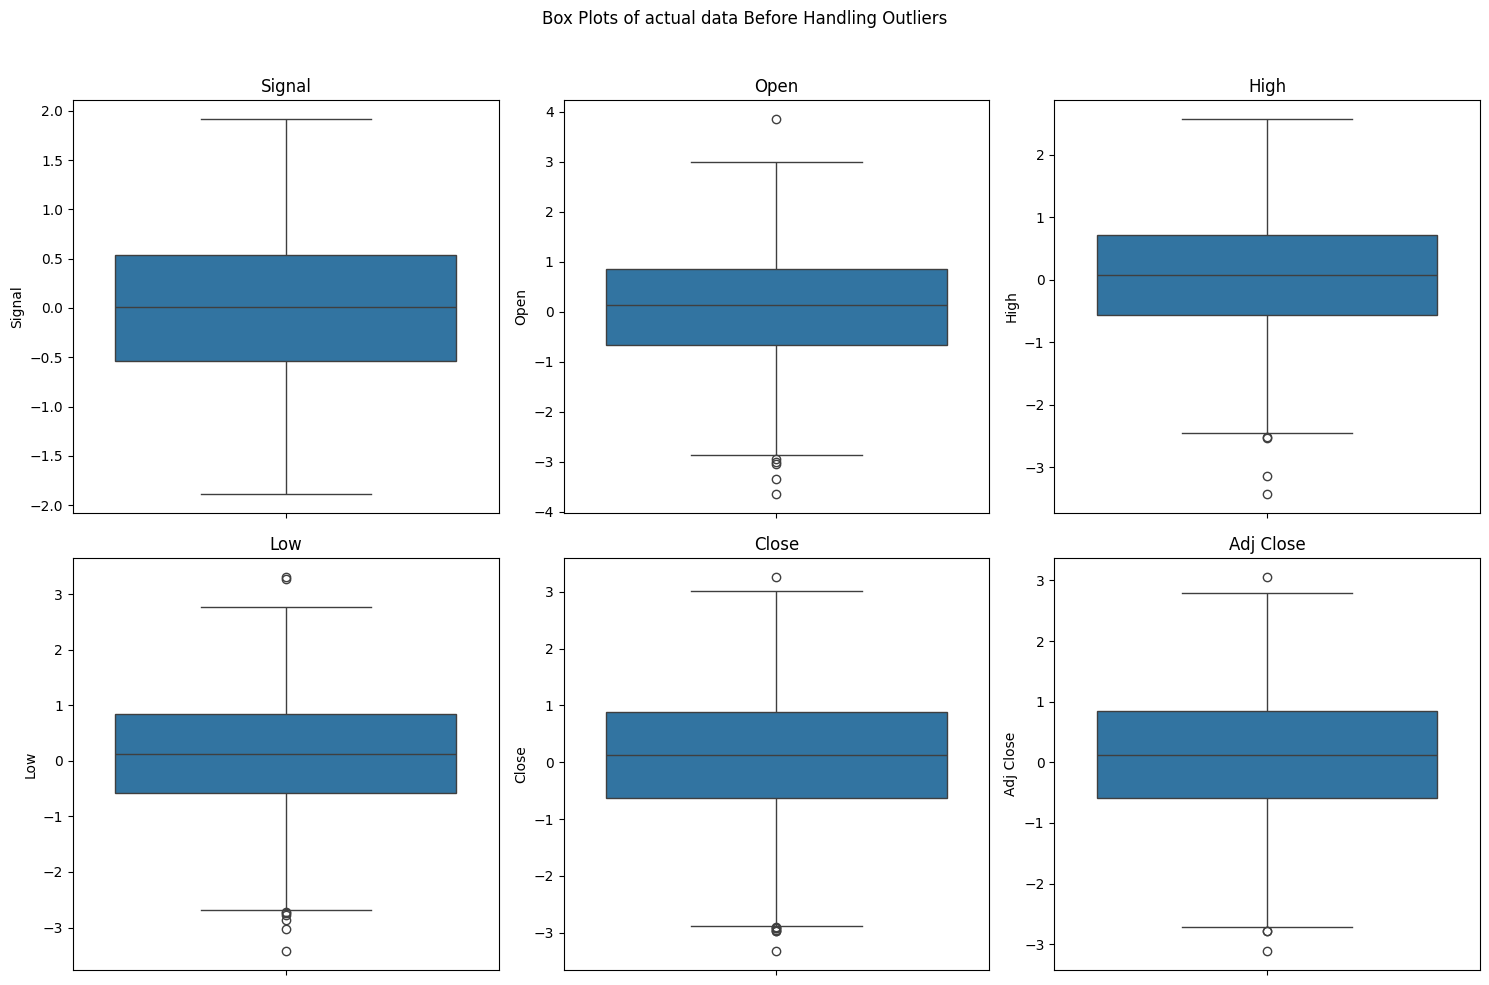

In [12]:
# Plot box plots before handling outliers
plt.figure(figsize=(15, 10))
plt.suptitle('Box Plots of actual data Before Handling Outliers')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df_diff_outliers_imputed[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### - Line graphs before outlier handling

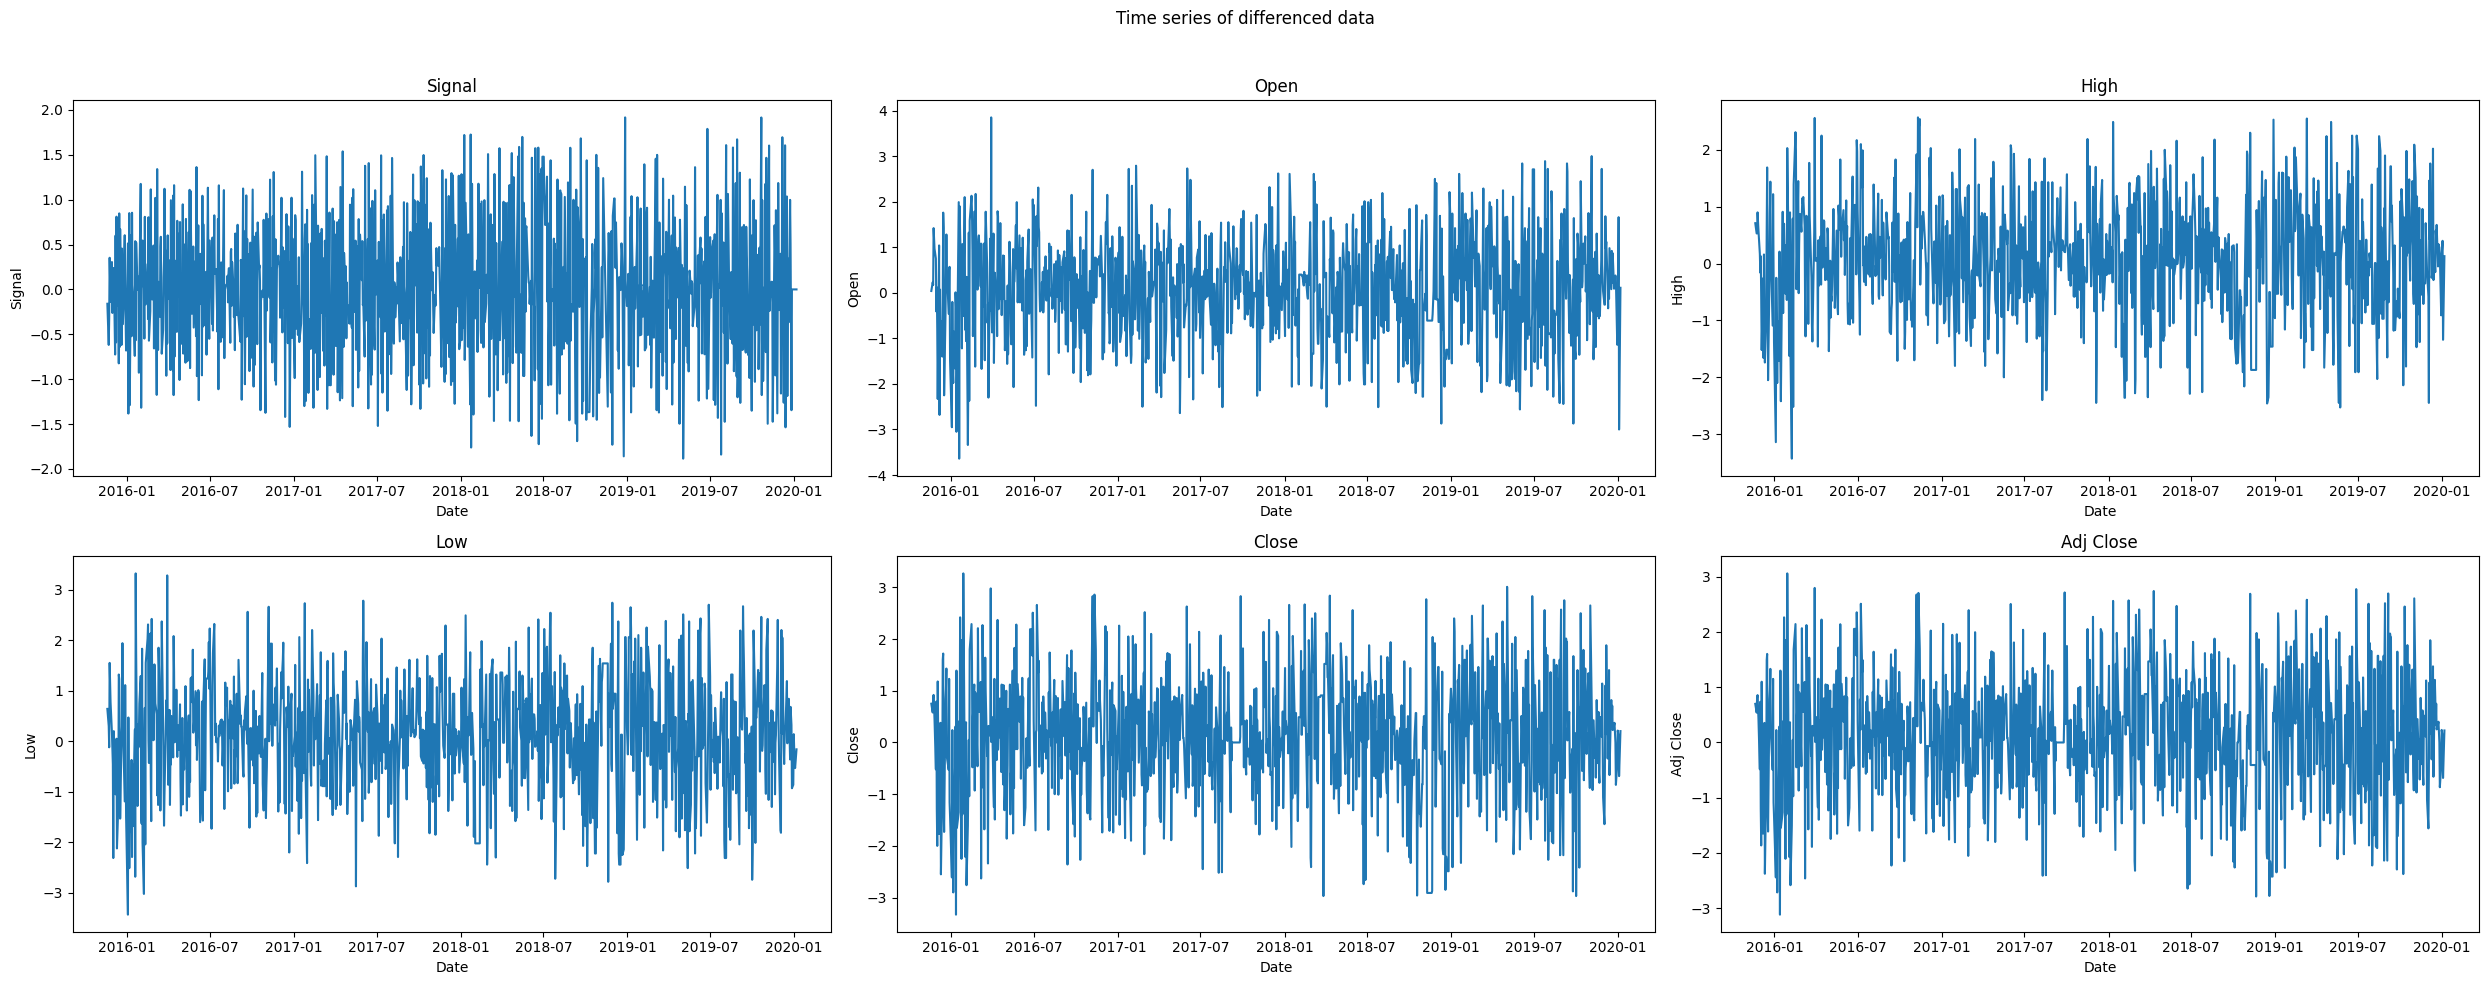

In [13]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Time series of differenced data')

for i, col in enumerate(columns_to_check, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_diff_outliers_imputed.Date, y=df_diff_outliers_imputed[col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

After differencing the data, the plots indicates that the data have a constant location and variance, hence the differenced data can be considered to be stationary.

## 2e. Other interesting exploratory data analysis
Moving average volatility 20 day window

In [67]:
# Calculate daily returns for given column
def calculate_daily_returns(df_temp, column, p = 1):
    df_temp[f'{column} Daily Return'] = df_temp[column].pct_change(periods = p)
    return df_temp.dropna()

# Calculate rolling volatility for given column
def calculate_rolling_volatility(df_temp, column, window=20):
    df_temp[f'{column} Rolling Volatility'] = df_temp[column].rolling(window=window).std() * np.sqrt(window)
    return df_temp.dropna()

# Main function
def analyze_volatility(df_temp):    
    # Calculate daily returns and rolling volatility for Adj Close
    # df_temp = calculate_daily_returns(df_temp, 'Adj Close')
    df_temp = calculate_rolling_volatility(df_temp, 'Adj Close')
    
    # Calculate daily returns and rolling volatility for Signal
    # df_temp = calculate_daily_returns(df_temp, 'Signal')
    df_temp = calculate_rolling_volatility(df_temp, 'Signal')
    
    return df_temp

# Load and analyze data
df_volatility = analyze_volatility(df_diff_outliers_imputed.copy())

# Output the results
print("Data with Daily Returns and Rolling Volatility:")
df_volatility

Data with Daily Returns and Rolling Volatility:


,Signal,Open,High,Low,Close,Adj Close,Date,Adj Close Rolling Volatility,Signal Rolling Volatility
38,-0.740135,1.989998,0.909996,0.229996,-1.350006,-1.265000,2016-01-19,6.192893,2.997806
39,0.537300,-3.640000,-0.869995,-2.680000,0.410003,0.384179,2016-01-20,6.189059,2.965628
40,-0.566443,1.900002,0.580002,3.319999,-0.230003,-0.215531,2016-01-21,6.040650,2.956057
41,0.522656,1.320000,0.699997,1.750000,2.420006,2.267624,2016-01-22,6.519270,2.969697
42,-0.002294,0.089996,-0.529999,-1.279999,-2.250000,-2.108314,2016-01-25,6.386001,2.969345
...,...,...,...,...,...,...,...,...,...
1032,0.000000,-1.139999,-0.909988,-0.859986,-0.419999,-0.415375,2019-12-30,3.625430,4.262670
1033,0.000000,-0.899994,0.139999,0.140000,0.229996,0.227447,2019-12-31,3.112449,4.242356
1034,0.000000,1.660003,0.399994,-0.480011,0.110001,0.108811,2020-01-02,3.004692,4.068898
1035,0.000000,-3.000000,-1.339996,-0.529999,-0.649994,-0.642853,2020-01-03,3.044832,4.066876


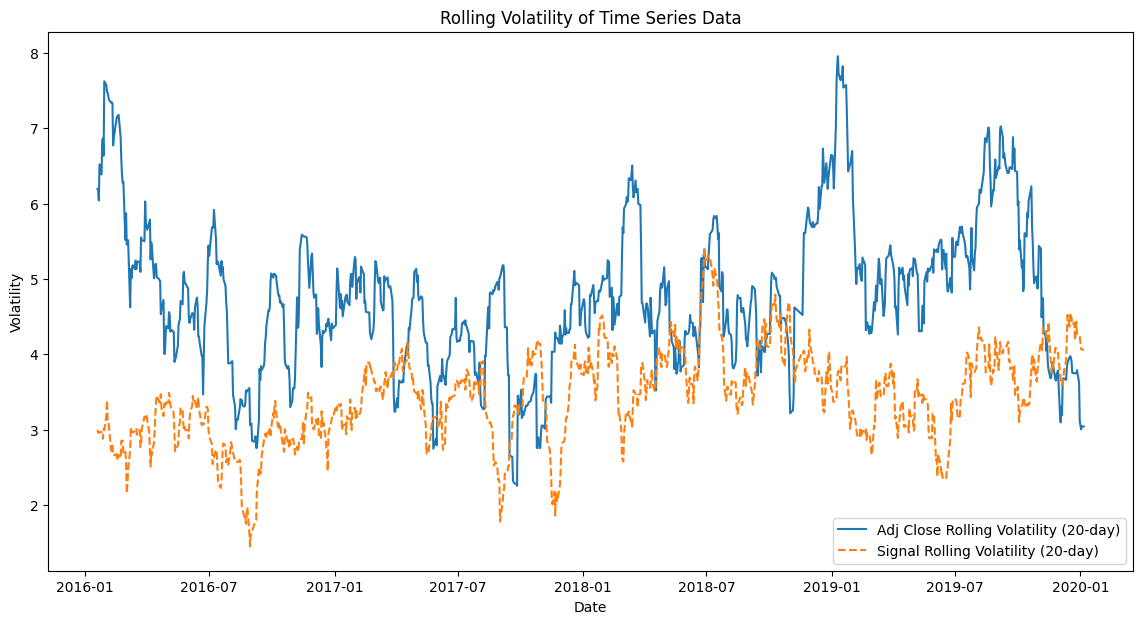

In [68]:
# Plotting the combined rolling volatility
plt.figure(figsize=(14, 7))
plt.plot(df_volatility['Date'], df_volatility['Adj Close Rolling Volatility'], label='Adj Close Rolling Volatility (20-day)')
plt.plot(df_volatility['Date'], df_volatility['Signal Rolling Volatility'], label='Signal Rolling Volatility (20-day)', linestyle='--')
plt.title('Rolling Volatility of Time Series Data')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

# 3. Please analyze the signal’s effectiveness or lack thereof in forecasting ETF price
Use whatever metrics you think are most relevant.

## 3a. Cross-correlation between Signal and ETF prices

We want to observe the correlation between signal and ETF prices to evaluate how well the signal's pattern matches ETF prices. Additionally, we also want to analyse if the signal columns actually matches farther horizons of ETF prices better.

In [14]:
horizons = 10
lags = ["Lag"+str(i) for i in range(horizons+1)]
etf_prices = ["Open", "High", "Low", "Close", "Adj Close"]

df_cross_corr = pd.DataFrame()
df_cross_corr["Lag_no"] = lags

for etf in etf_prices:
    collated_corr = []
    for horizon in range(horizons+1):
        # df_diff_temp = get_differenced_data(df.copy(), horizon)
        df_lagged = df_diff.copy()
        if horizon != 0:
            df_lagged["Signal"] = df_diff["Signal"].shift(horizon)
            df_lagged = df_lagged.dropna()
        collated_corr.append(abs(np.corrcoef(df_lagged["Signal"], df_lagged[etf])[0][1]))
    df_cross_corr["Signal-"+etf] = collated_corr

df_cross_corr


,Lag_no,Signal-Open,Signal-High,Signal-Low,Signal-Close,Signal-Adj Close
0,Lag0,0.003330,0.022198,0.011773,0.005776,0.023589
1,Lag1,0.027416,0.020841,0.017287,0.015307,0.025731
2,Lag2,0.050550,0.049524,0.013156,0.052106,0.102704
3,Lag3,0.029420,0.064496,0.038021,0.062016,0.231563
4,Lag4,0.024686,0.002555,0.026192,0.014621,0.116024
5,Lag5,0.005892,0.007958,0.017439,0.027300,0.025175
6,Lag6,0.037767,0.063929,0.073099,0.045887,0.036378
7,Lag7,0.075552,0.062230,0.058901,0.021834,0.002521
8,Lag8,0.025402,0.001746,0.012340,0.007456,0.002803
9,Lag9,0.032741,0.035765,0.015158,0.027273,0.012821


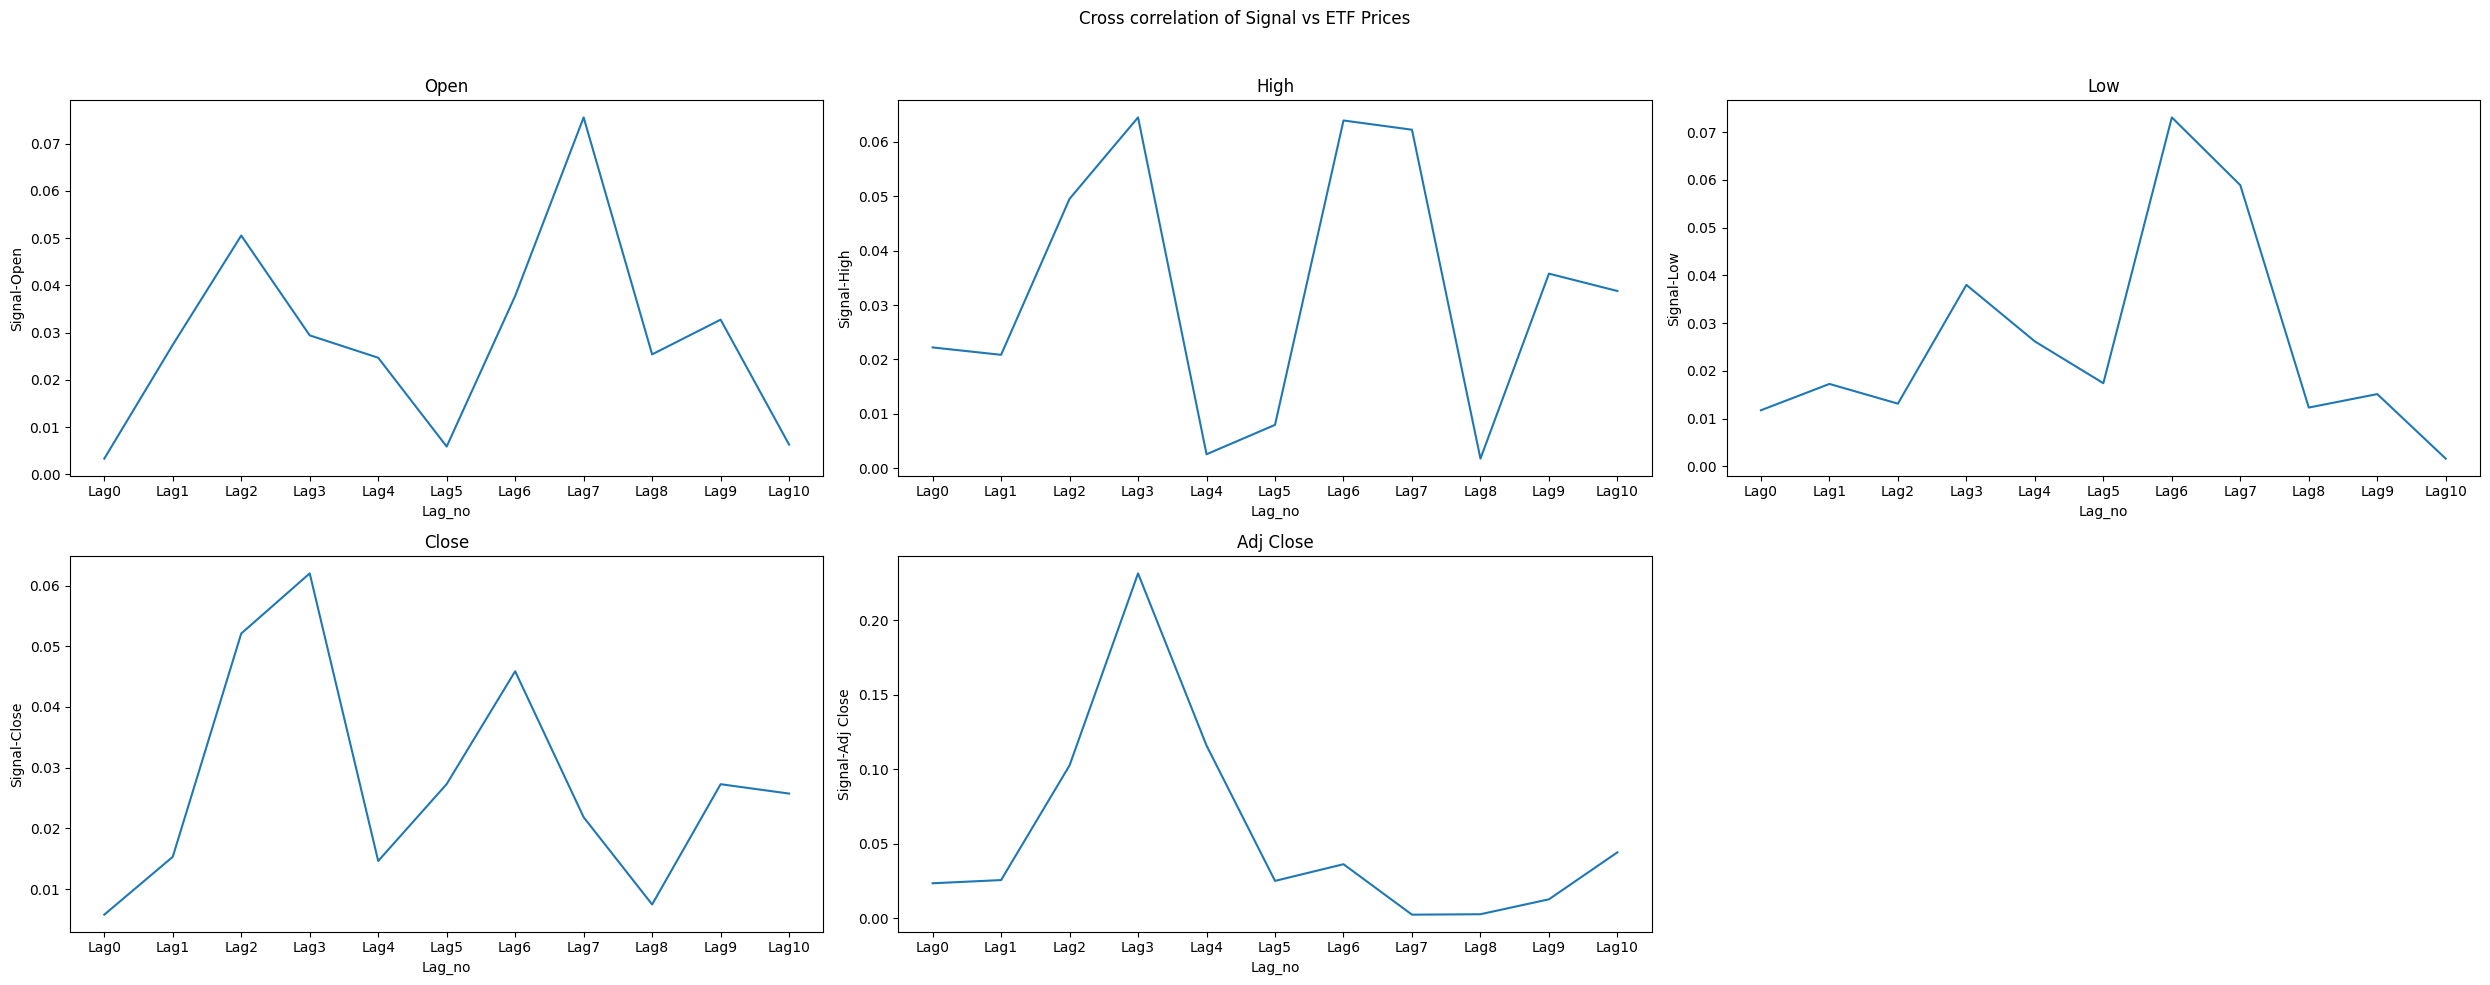

In [15]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Cross correlation of Signal vs ETF Prices')

for i, col in enumerate(etf_prices, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_cross_corr.Lag_no, y=df_cross_corr["Signal-"+col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

From the above graph, we can see that the rate of change of signal has the highest correlation with adjusted close ETF returns at lag 6/7. This can mean that the signal from 6/7 time lags ago is the best at predicting today's adjusted close ETF. However even so, the maximum correlation between the signal and the adjusted close ETF returns is at 0.3, which is low. Hence, it can be inferred here that signal may not be a good predictor of adjusted close ETF returns.


In [16]:
# With outliers
df_cross_corr_outliers = pd.DataFrame()
df_cross_corr_outliers["Lag_no"] = lags

for etf in etf_prices:
    collated_corr = []
    for horizon in range(horizons+1):
        # df_diff_temp = get_differenced_data(df.copy(), horizon)
        df_lagged = df_diff_outliers_imputed.copy()
        if horizon != 0:
            df_lagged["Signal"] = df_diff["Signal"].shift(horizon)
            df_lagged = df_lagged.dropna()
        collated_corr.append(abs(np.corrcoef(df_lagged["Signal"], df_lagged[etf])[0][1]))
    df_cross_corr_outliers["Signal-"+etf] = collated_corr

df_cross_corr_outliers


,Lag_no,Signal-Open,Signal-High,Signal-Low,Signal-Close,Signal-Adj Close
0,Lag0,0.004207,0.009890,0.012193,0.011375,0.003295
1,Lag1,0.003036,0.003223,0.007116,0.002466,0.007742
2,Lag2,0.025764,0.040680,0.004794,0.006661,0.010620
3,Lag3,0.050260,0.074150,0.037610,0.060612,0.059237
4,Lag4,0.008409,0.017284,0.009523,0.006596,0.018535
5,Lag5,0.005308,0.022586,0.022068,0.020839,0.022925
6,Lag6,0.015062,0.049467,0.071888,0.105928,0.093526
7,Lag7,0.062141,0.073534,0.047015,0.018866,0.030330
8,Lag8,0.045410,0.000604,0.019053,0.006578,0.009827
9,Lag9,0.035267,0.038117,0.009097,0.036812,0.033001


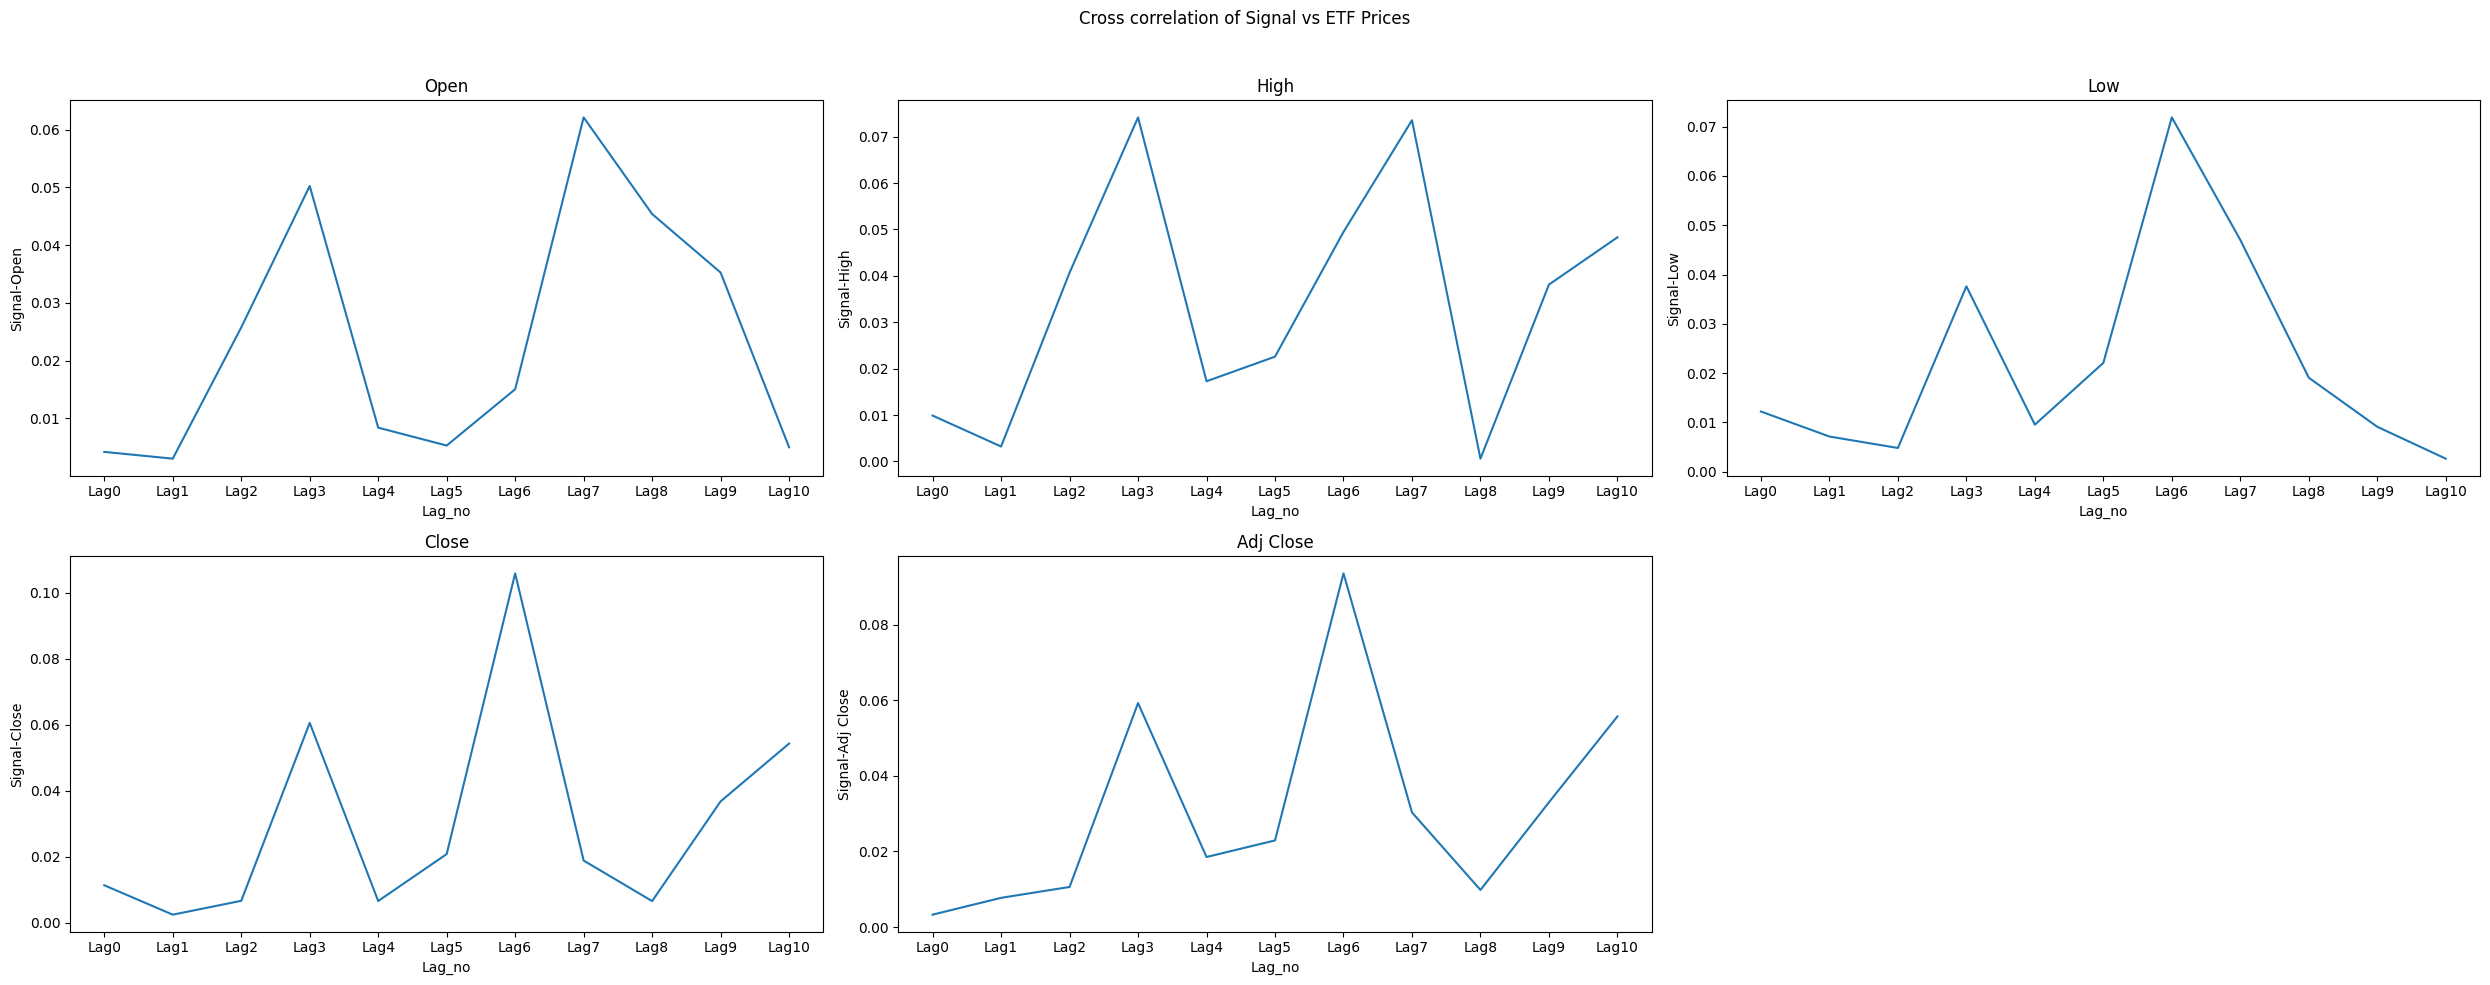

In [17]:
# Plot time series
plt.figure(figsize=(25, 10))
plt.suptitle('Cross correlation of Signal vs ETF Prices')

for i, col in enumerate(etf_prices, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(x=df_cross_corr_outliers.Lag_no, y=df_cross_corr_outliers["Signal-"+col])
    plt.title(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3b. Evaluate against Baseline: Naive

For our baseline model, we used naive, which is taking the lag of adjusted close as next horizon forecast. This is an important baseline model to beat as if naive performs better than our other models later, it would mean that the time series data might not have strong patterns or that the complexity of the model is unnecessary for capturing the underlying dynamics of the data. 

We also used differenced data for our training and forecasting in order to ensure that stationarity is present.

To ensure fair test between Signal and Naive, we also quantify the percentage of times Signal as a predictor outperforms Naive, as outlier prediction can drive up MAE unfairly. 

In [71]:
# Returns the % of wins Signal has against the baseline
def perc_beat_baseline(model_pred, baseline, y_test):
    score_df = pd.DataFrame()
    score_df["model vs baseline"] = (baseline - y_test).abs() - (model_pred - y_test).abs()

    return len(score_df[score_df["model vs baseline"] > 0])/len(score_df)

In [72]:
test_sets = df_diff.iloc[6:,:].copy()
print(test_sets.shape)

(1031, 7)


In [73]:
models_performance_mae = pd.DataFrame()
models_performance_mae["Prices"] = etf_prices

models_performance_pw = pd.DataFrame()
models_performance_pw["Prices"] = etf_prices

naive_pred_all = df_diff[["Date"] + etf_prices].copy()[-len(test_sets):]

naive_mae = []
naive_dir_score = []
for etf in etf_prices:
    naive_pred_all[etf] = 0
    naive_pred = naive_pred_all[etf]
    mae = format(mean_absolute_error(naive_pred, test_sets[etf]), ".2f")  
    std = format(np.std(naive_pred), ".2f")  

    naive_mae.append(str(mae) + " (" + str(std) + ")")
    naive_dir_score.append(dir)

models_performance_mae["Naive"] = naive_mae

In [74]:
# Vs Signal
signal_mae = []
signal_pw = []
# Adjust dataset for fair test
signal_pred = df_diff[["Date", "Signal"]][-len(test_sets):].copy()
for etf in etf_prices:
    mae = format(mean_absolute_error(signal_pred["Signal"], test_sets[etf]), ".2f")  
    perc_win = format(perc_beat_baseline(signal_pred["Signal"], naive_pred_all[etf], test_sets[etf]), ".2f")
    std = format(np.std(signal_pred["Signal"]), ".2f")  

    signal_mae.append(str(mae) + " (" + str(std) + ")")
    signal_pw.append(perc_win)

models_performance_mae["Signal"] = signal_mae
models_performance_pw["Signal"] = signal_pw

In [75]:
# Vs Signal
signal_mae = []
signal_pw = []
# Adjust dataset for fair test
signal_pred_lag = df_diff[["Signal"]].shift(6).copy()[-len(test_sets):]
signal_pred_lag["Date"] = df_diff["Date"].copy()[-len(test_sets):]

for etf in etf_prices:
    mae = format(mean_absolute_error(signal_pred_lag["Signal"], test_sets[etf]), ".2f")  
    perc_win = format(perc_beat_baseline(signal_pred_lag["Signal"], naive_pred_all[etf], test_sets[etf]), ".2f")
    std = format(np.std(signal_pred_lag["Signal"]), ".2f")  

    signal_mae.append(str(mae) + " (" + str(std) + ")")
    signal_pw.append(perc_win)

models_performance_mae["Signal at lag 6"] = signal_mae
models_performance_pw["Signal at lag 6"] = signal_pw

In [76]:
# Vs Signal
signal_mae = []
signal_pw = []
# Adjust dataset for fair test
signal_pred_outlier = df_diff_outliers_imputed[["Date", "Signal"]][-len(test_sets):]

for etf in etf_prices:
    mae = format(mean_absolute_error(signal_pred_outlier["Signal"], test_sets[etf]), ".2f")  
    perc_win = format(perc_beat_baseline(signal_pred_outlier["Signal"], naive_pred_all[etf], test_sets[etf]), ".2f")
    std = format(np.std(signal_pred_outlier["Signal"]), ".2f")  

    signal_mae.append(str(mae) + " (" + str(std) + ")")
    signal_pw.append(perc_win)

models_performance_mae["Signal (Outlier Handling)"] = signal_mae
models_performance_pw["Signal (Outlier Handling)"] = signal_pw

In [77]:
# Vs Signal
signal_mae = []
signal_pw = []
# Adjust dataset for fair test
signal_pred_outlier_lag = df_diff_outliers_imputed[["Signal"]].shift(6).copy()[-len(test_sets):]
signal_pred_outlier_lag["Date"] = df_diff_outliers_imputed["Date"].copy()[-len(test_sets):]

for etf in etf_prices:
    mae = format(mean_absolute_error(signal_pred_outlier_lag["Signal"], test_sets[etf]), ".2f")  
    perc_win = format(perc_beat_baseline(signal_pred_outlier_lag["Signal"], naive_pred_all[etf], test_sets[etf]), ".2f")
    std = format(np.std(signal_pred_outlier_lag["Signal"]), ".2f")  

    signal_mae.append(str(mae) + " (" + str(std) + ")")
    signal_pw.append(perc_win)

models_performance_mae["Signal at lag 6 (Outlier Handling)"] = signal_mae
models_performance_pw["Signal at lag 6 (Outlier Handling)"] = signal_pw
models_performance_mae

,Prices,Naive,Signal,Signal at lag 6,Signal (Outlier Handling),Signal at lag 6 (Outlier Handling)
0,Open,1.05 (0.00),1.30 (1.21),1.28 (1.21),1.22 (0.76),1.22 (0.76)
1,High,0.89 (0.00),1.20 (1.21),1.13 (1.21),1.12 (0.76),1.07 (0.76)
2,Low,1.00 (0.00),1.26 (1.21),1.20 (1.21),1.20 (0.76),1.14 (0.76)
3,Close,1.13 (0.00),1.39 (1.21),1.31 (1.21),1.32 (0.76),1.25 (0.76)
4,Adj Close,1.15 (0.00),1.42 (1.21),1.33 (1.21),1.34 (0.76),1.28 (0.76)


In [78]:
models_performance_pw

,Prices,Signal,Signal at lag 6,Signal (Outlier Handling),Signal at lag 6 (Outlier Handling)
0,Open,0.39,0.40,0.39,0.40
1,High,0.35,0.40,0.35,0.40
2,Low,0.37,0.41,0.37,0.42
3,Close,0.37,0.43,0.38,0.43
4,Adj Close,0.37,0.43,0.38,0.43


## 3c. Performance of Signal against Naive by Year

To ensure that the high MAE of the Signal is not as a result of the underperformance of outlier time periods, we are also interested in monitoring the change in metrics over the years, and evaluate if Signal as a predictor consistently underperforms Naive.

In [86]:
forecast_years = test_sets['Date'].dt.year.unique().tolist()
forecasts = [naive_pred_all, signal_pred, signal_pred_lag, signal_pred_outlier, signal_pred_outlier_lag]
model_names = models_performance_mae.columns.to_list()[1:]

models_performance_mae_by_year = pd.DataFrame()
models_performance_mae_by_year["Year"] = forecast_years

models_performance_pw_by_year = pd.DataFrame()
models_performance_pw_by_year["Year"] = forecast_years

for i, model in enumerate(forecasts):
    mae = []
    pw = []
    year_counts_all = []
    
    for year in forecast_years:
        model_by_year = model[model["Date"].dt.year==year].copy()

        test_set_by_year = test_sets[test_sets["Date"].dt.year==year].copy()
        if "naive" in model_names[i].lower():
            pred = model_by_year["Adj Close"]
        else:
            pred = model_by_year["Signal"]

            naive_by_year = forecasts[0][forecasts[0]["Date"].dt.year==year].copy()
            pw.append(format(perc_beat_baseline(pred, naive_by_year["Adj Close"], test_set_by_year["Adj Close"]), ".2f"))

        mae.append(mean_absolute_error(pred, test_set_by_year["Adj Close"]))

        year_counts_all.append(len(test_set_by_year))

    models_performance_mae_by_year[model_names[i]] = mae
    
    if "naive" not in model_names[i].lower():
        models_performance_pw_by_year[model_names[i]] = pw

models_performance_mae_by_year["Sample Count"] = year_counts_all
models_performance_mae_by_year


,Year,Naive,Signal,Signal at lag 6,Signal (Outlier Handling),Signal at lag 6 (Outlier Handling),Sample Count
0,2015,1.138056,1.116028,1.102960,1.116028,1.102960,22
1,2016,1.243047,1.496629,1.408997,1.408498,1.327340,252
2,2017,0.990522,1.425036,1.354659,1.257901,1.209483,252
3,2018,1.238025,1.475460,1.419982,1.399995,1.416818,250
4,2019,1.146655,1.322327,1.172815,1.322327,1.172815,252
5,2020,0.323080,0.323080,1.199989,0.323080,1.199989,3


In [87]:
models_performance_pw_by_year

,Year,Signal,Signal at lag 6,Signal (Outlier Handling),Signal at lag 6 (Outlier Handling)
0,2015,0.55,0.55,0.55,0.55
1,2016,0.39,0.45,0.40,0.46
2,2017,0.31,0.35,0.31,0.35
3,2018,0.39,0.40,0.40,0.40
4,2019,0.38,0.50,0.38,0.50
5,2020,0.00,0.00,0.00,0.00


## Feature selection with regularized regressions
- For the upcoming models, we will be using signal as a feature to predict adjusted close price. Signal will be lagged at 7 days or more depending on the forecast horizon since the cross correlation graph has shown that lag 7 is when correlation with the adjusted close price is at its highest
- For non-time series regressions, we also use lagged adjusted prices as an additional feature to account for momentum.

In [104]:
def setup_data_for_modelling(df_temp, forecast_horizon):
    df_for_regression = df_temp.copy()
    df_for_regression = df_for_regression.rename(columns={"Adj Close": "y"})
    cols_to_lag = [c for c in df_for_regression.columns if c not in ["Date", "y", "Signal"]]

    # We need to shift the features to ensure fair forecasting
    if forecast_horizon > 7:
        df_for_regression["Signal"] = df_for_regression["Signal"].shift(forecast_horizon)
    else:
        df_for_regression["Signal"] = df_for_regression["Signal"].shift(7)
    df_for_regression[cols_to_lag] = df_for_regression[cols_to_lag].shift(forecast_horizon)
    # Create lags for linear regression
    lags_required = 1
    for l in range(forecast_horizon, forecast_horizon+lags_required):
        df_for_regression["lag"+str(l)] = df_for_regression["y"].shift(l)

    return df_for_regression.dropna()

In [105]:
df_for_regression = setup_data_for_modelling(df_volatility.copy(), h)
X, y, X_train, X_test, y_train, y_test = get_standard_train_test_split(df_for_regression, test_ratio=0.2, is_not_time_series = False)

### ARIMA Model
From the ACF & PACF graph above, we concluded that there is a MA component in the ARIMA model. Furthermore, in our decomposition graph earlier, we also concluded that there is likely to be no seasonality in the adjusted close ETF price. Hence for this exercise, we will be using an ARIMA model with order (0,0,1)

Actual Adj Close Price vs Predicted Adj Close Price
Mean Absolute Error: 0.92 (0.01)
Std: 0.01


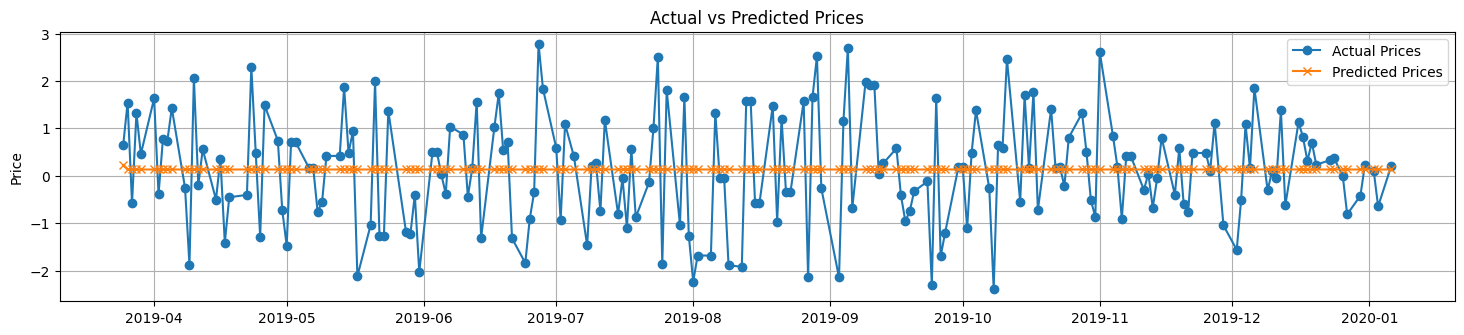

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  793
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1176.112
Date:                Fri, 14 Jun 2024   AIC                           2358.225
Time:                        17:44:27   BIC                           2372.252
Sample:                             0   HQIC                          2363.616
                                - 793                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1348      0.040      3.378      0.001       0.057       0.213
ma.L1          0.0525      0.033      1.586      0.113      -0.012       0.117
sigma2         1.1369      0.058     19.557      0.0

In [109]:
# For fair test, let's get the same test size as the regressors
test_size = len(y_test)

# Modify df for time-series model
df_arima = df_for_regression.copy()
df_arima = df_arima.set_index('Date').asfreq('D').dropna() 
features = ["Adj Close Rolling Volatility"]

X, y, X_train, X_test, y_train, y_test = get_standard_train_test_split(df_arima[["y"] + features], test_ratio=0.2, is_not_time_series = False)

model = ARIMA(y_train, order=(0,0,1))
arima_fit = model.fit()
# Predict future prices using the signal
pred = arima_fit.forecast(steps = len(X_test)).values

mae = mean_absolute_error(pred, y_test)

# models_performance["Arima"] = [mae, rmse, np.std(pred)]

# models_performance["Lasso"] = [mae, r2, np.std(pred)]

print(f'\033[1mActual Adj Close Price vs Predicted Adj Close Price\033[0m')
print(f'Mean Absolute Error: {mae:.2f} ({np.std(pred):.2f})')
print(f'Std: {np.std(pred):.2f}')

# To visualise the performance of the model
plt.figure(figsize = (18, 3.5))
plt.plot(y_test.index, y_test.values, label = 'Actual Prices', marker = 'o')
plt.plot(y_test.index, pred, label = 'Predicted Prices', marker = 'x')
plt.title('Actual vs Predicted Prices')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

print(arima_fit.summary())

From the summary table above, we can see that the coefficient of signal has a p-value > 0.05, hence it is statistically insignificant at 5% significance level. We can infer that signal is not effectivene in forecasting adjusted close ETF returns.

In [ ]:
print("Results for forecasting Adjusted Close " + str(h) + " day(s) ahead:")
pd.DataFrame.from_dict(models_performance, orient='index', columns=["MAE", "RMSE", "STD"])

Results for forecasting Adjusted Close 1 day(s) ahead:


,MAE,RMSE,STD
Naive,1.721144,2.206713,1.495376
Lasso,1.133007,1.512140,0.396335
RandomForest,1.215418,1.606458,0.573076
Arima,1.159991,1.529029,0.401857


From the table above, we can see that all other models have managed to beat naive in terms of MAE and RMSE scores. However, as analysed above, it would seem that signal, in general, is not an effective feature to forecast adjusted close ETF price one day ahead.